# Big Data Technologies Mini-Project

## Name of Student: Anna Basanskaya

## Mini Project Instructions:

### Goal of project:
Suppose you want to launch a $\color{green}{\mbox{dining}}$ business in the U.S. but you haven't decided its details yet.
Use Big Data Technologies you learned from this course to help you make the following decisions:

 - Location of the business:
 Choose the cluster with highest average OPEN rate. 


 - Type of business: based on the clustering result, within the best cluster, use yelp_review.csv to classify those dining business into 
    - American Food
    - Asian Fusion (Chinese, Indian, Japanese, Korean, Thai food and so on)
    - Frech Food
    - Italian Food
    - Mexican Food


 - Choose type of business: build classification model for Stars per Food type. Then choose the highest average stars.

# Set up

## Start Spark session

In [1]:
B_USE_HADOOP = False #Don't need to use it for the practice runs

In [2]:
if B_USE_HADOOP:
    YELP_DIR= "hdfs://localhost:50000/yelpDir/"
else:
    YELP_DIR = "H:/Baruch/spark_source_code/"

In [3]:
# import SparkContext function to create new spark contexts for use
from pyspark.context import SparkContext
# import SparkSession function to create new spark sessions for use
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as f

In [4]:
import warnings
try:
    # create new spark context for RDDs
    sc_p = SparkContext('local[2]').getOrCreate() 
except ValueError:
    warnings.warn("SparkContext already exists in this scope")
# under the spark context sc_p, create new spark session called spark_p for dataframes
spark_p = SparkSession(sc_p).builder.master("local[*]").appName('yelp_project').getOrCreate() # entrypoint for dataframes in Spark 2+

Print version information.

In [5]:
import platform
print("Python version: %s" %platform.python_version())
print("Spark version: %s" %sc_p.version)

Python version: 2.7.14
Spark version: 2.3.0


Print configuration information.

In [6]:
sc_p.getConf().getAll()

[(u'spark.driver.port', u'59894'),
 (u'spark.app.name', u'yelp_project'),
 (u'spark.app.id', u'local-1550356630917'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.master', u'local[*]'),
 (u'spark.executor.id', u'driver'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.driver.host', u'Annyutka-PC'),
 (u'spark.ui.showConsoleProgress', u'true'),
 (u'spark.driver.cores', u'8')]

## Load yelp business data

In [7]:
yelp_business_for_header = sc_p.textFile(YELP_DIR + "yelp_business.csv")

In [8]:
yelp_business_for_header1= yelp_business_for_header.map(lambda x: x.replace('"""', '"'))

The line below only needs to be run once to save a temporary file.

In [9]:
#yelp_business_for_header1.saveAsTextFile(YELP_DIR + "yelp_business1/")

In [10]:
yelp_business_data_init= spark_p.read .option('header','true') .option('inferSchema', 'true') .csv(YELP_DIR+"yelp_business1/part-00000")

Make sure it is a dataframe.

In [11]:
type(yelp_business_data_init)

pyspark.sql.dataframe.DataFrame

Look at a summary.

In [12]:
yelp_business_data_init.describe('state', 'latitude', 'longitude', 'stars').show()

+-------+-----------------+------------------+------------------+------------------+
|summary|            state|          latitude|         longitude|             stars|
+-------+-----------------+------------------+------------------+------------------+
|  count|            87364|             87365|             87365|             87365|
|   mean|4.777777777777778|38.685862264148135|-92.44736824787608|3.6315057517312423|
| stddev|9.601793813889385| 5.357779036823527|26.257093584405386| 1.000286864320979|
|    min|               01|        -36.086009|      -122.4993871|               1.0|
|    max|              XGL|     59.4381813808|     14.0926355127|               5.0|
+-------+-----------------+------------------+------------------+------------------+



Look into why state has numeric values. Maybe a data problem or could relfect non-US states.

In [13]:
yelp_business_data_init.select('state', 'stars').sort('state', ascending=True).show()

+-----+-----+
|state|stars|
+-----+-----+
| null|  5.0|
|   01|  3.5|
|   01|  4.0|
|   01|  3.5|
|   01|  5.0|
|   01|  4.5|
|   01|  2.5|
|   01|  3.0|
|   30|  3.0|
|    6|  3.0|
|  ABE|  4.5|
|  ABE|  4.5|
|   AK|  2.5|
|   AL|  5.0|
|   AR|  1.5|
|   AZ|  4.0|
|   AZ|  3.0|
|   AZ|  2.0|
|   AZ|  3.0|
|   AZ|  3.5|
+-----+-----+
only showing top 20 rows



In [14]:
yelp_business_data_init.where(yelp_business_data_init.state.isNull()).show()

+--------------------+----------+------------+--------------------+----------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|         business_id|      name|neighborhood|             address|            city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|
+--------------------+----------+------------+--------------------+----------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|SLqpLeF3gq6nnx6_J...|5150 Wraps|        null|250 Sunpac Ave, S...|Henderson Nevada| null|      89015|36.0695210053|-114.996330924|  5.0|          12|      1|Auto Customizatio...|
+--------------------+----------+------------+--------------------+----------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+



Drop null and NA values.

In [15]:
yelp_business_data = yelp_business_data_init.na.drop(subset=
                                                     ["business_id", "name", "city", "state",\
                                                     "postal_code", "latitude", "longitude",\
                                                     "stars", "review_count", "is_open", "categories"])

Examine the new data set to make sure null and na values have been dropped.

In [16]:
yelp_business_data.describe('state', 'latitude', 'longitude', 'stars').show()

+-------+-----------------+------------------+------------------+------------------+
|summary|            state|          latitude|         longitude|             stars|
+-------+-----------------+------------------+------------------+------------------+
|  count|            87047|             87047|             87047|             87047|
|   mean|4.777777777777778|38.686839705909776|-92.44750400352214|3.6314634622675106|
| stddev|9.601793813889385|5.3439448707529955|26.250931440704566|0.9991170186085166|
|    min|               01|        -36.086009|      -122.4993871|               1.0|
|    max|              XGL|     59.4381813808|     14.0926355127|               5.0|
+-------+-----------------+------------------+------------------+------------------+



### Visualize latitude and longitude

First convert to a pandas dataframe.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
yelp_business_geo = yelp_business_data.select('latitude','longitude', 'is_open')
yelp_business_geo.show(5, False)

### use toPandas member function of Spark DataFrame to get a Pandas DataFrame
### only a good idea for small datasets
yelp_business_geo_pd = yelp_business_geo.toPandas()

+----------+------------+-------+
|latitude  |longitude   |is_open|
+----------+------------+-------+
|33.3306902|-111.9785992|1      |
|40.2916853|-80.1048999 |1      |
|33.5249025|-112.1153098|1      |
|33.3831468|-111.9647254|0      |
|41.1195346|-81.4756898 |1      |
+----------+------------+-------+
only showing top 5 rows



Plot the longitude and latitude of all businesses, color coded by whether or not they are open.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87047 entries, 0 to 87046
Data columns (total 3 columns):
latitude     87047 non-null float64
longitude    87047 non-null float64
is_open      87047 non-null int32
dtypes: float64(2), int32(1)
memory usage: 1.7 MB


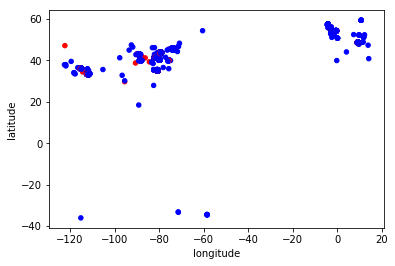

In [18]:
### call member function apply to apply to_numeric function to all columns
### to_numeric function changes its input into numeric data type
yelp_business_geo_pd = yelp_business_geo_pd.apply(pd.to_numeric)
yelp_business_geo_pd.info()

### use Pandas Dataframe member function plot to make scatter plot 
###     of longitude and lontitude of all business units.
### use matplotlib function plt to show the plot.
colors = {0: 'r', 1: 'b'}
yelp_business_geo_pd.plot(kind='scatter', x='longitude', y='latitude', color=[colors[i] for i in yelp_business_geo_pd['is_open']])
plt.show()

### Filter down to US dining businesses

First look at the data.

In [20]:
yelp_business_data.groupby('state').avg(*['stars']).show()

+-----+------------------+
|state|        avg(stars)|
+-----+------------------+
|   AZ|3.7275238771805195|
|   SC|3.6024590163934427|
|   SL|               5.0|
|   BW|3.8152446675031366|
|   MN|               3.5|
|   30|               3.0|
|  FAL|               4.0|
|  KHL|               3.5|
|   01|3.7142857142857144|
|  NYK|         3.7421875|
|  NTH|               3.5|
|  HLD|3.6923076923076925|
|  SCB|               4.0|
|   VA|               4.0|
|   QC| 3.657225156024964|
|  ESX| 4.142857142857143|
|   NV| 3.716891810396816|
|  GLG|               4.5|
|   WI| 3.637182637182637|
|   CA|               4.5|
+-----+------------------+
only showing top 20 rows



In [21]:
yelp_business_data.select('city', 'state', 'postal_code').show(10,False)

+--------------+-----+-----------+
|city          |state|postal_code|
+--------------+-----+-----------+
|Ahwatukee     |AZ   |85044      |
|McMurray      |PA   |15317      |
|Phoenix       |AZ   |85017      |
|Tempe         |AZ   |85282      |
|Cuyahoga Falls|OH   |44221      |
|Stuttgart     |BW   |70567      |
|Las Vegas     |NV   |89128      |
|Las Vegas     |NV   |89128      |
|Wexford       |PA   |15090      |
|Henderson     |NV   |89014      |
+--------------+-----+-----------+
only showing top 10 rows



Create a list containing the state abbreviations for the US.

In [22]:
STATES = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

Keep only US businesses.

In [23]:
yelp_business_us_data = yelp_business_data.where(f.col('state').isin(STATES))

In [24]:
yelp_business_us_data.select('city','state', 'postal_code').show(10,False)

+--------------+-----+-----------+
|city          |state|postal_code|
+--------------+-----+-----------+
|Ahwatukee     |AZ   |85044      |
|McMurray      |PA   |15317      |
|Phoenix       |AZ   |85017      |
|Tempe         |AZ   |85282      |
|Cuyahoga Falls|OH   |44221      |
|Las Vegas     |NV   |89128      |
|Las Vegas     |NV   |89128      |
|Wexford       |PA   |15090      |
|Henderson     |NV   |89014      |
|Houston       |PA   |15342      |
+--------------+-----+-----------+
only showing top 10 rows



Keep only dining businesses

In [25]:
yelp_business_dining = \
    yelp_business_us_data.filter(yelp_business_us_data.categories.contains('Restaurants')\
                                | yelp_business_us_data.categories.contains('Food'))

In [26]:
print(type(yelp_business_dining))
print(yelp_business_dining.columns)
print(yelp_business_dining.columns[8])
print(yelp_business_dining.columns[7])
print(yelp_business_dining.columns[11])

<class 'pyspark.sql.dataframe.DataFrame'>
['business_id', 'name', 'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'categories']
longitude
latitude
is_open


View the top few records.

In [27]:
print(yelp_business_dining.take(10))


[Row(business_id=u'PfOCPjBrlQAnz__NXj9h_w', name=u'Brick House Tavern + Tap', neighborhood=None, address=u'581 Howe Ave', city=u'Cuyahoga Falls', state=u'OH', postal_code=u'44221', latitude=41.1195346, longitude=-81.4756898, stars=3.5, review_count=116, is_open=1, categories=u'American (New);Nightlife;Bars;Sandwiches;American (Traditional);Burgers;Restaurants'), Row(business_id=u'EsMcGiZaQuG1OOvL9iUFug', name=u'Any Given Sundae', neighborhood=None, address=u'2612 Brandt School Rd', city=u'Wexford', state=u'PA', postal_code=u'15090', latitude=40.6151022445, longitude=-80.0913487465, stars=5.0, review_count=15, is_open=1, categories=u'Coffee & Tea;Ice Cream & Frozen Yogurt;Food'), Row(business_id=u'XOSRcvtaKc_Q5H1SAzN20A', name=u'East Coast Coffee', neighborhood=None, address=u'737 West Pike St', city=u'Houston', state=u'PA', postal_code=u'15342', latitude=40.2415480142, longitude=-80.2128151059, stars=4.5, review_count=3, is_open=0, categories=u'Breakfast & Brunch;Gluten-Free;Coffee & T

# Clustering

### Visualize the clusters before fitting kmeans

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20867 entries, 0 to 20866
Data columns (total 3 columns):
latitude     20867 non-null float64
longitude    20867 non-null float64
is_open      20867 non-null int32
dtypes: float64(2), int32(1)
memory usage: 407.6 KB


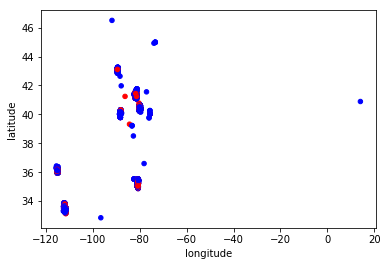

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### call member function apply to apply to_numeric function to all columns
### to_numeric function changes its input into numeric data type
yelp_business_dining_geo_pd = yelp_business_dining.select('latitude','longitude', 'is_open').toPandas()
yelp_business_dining_geo_pd = yelp_business_dining_geo_pd.apply(pd.to_numeric)
yelp_business_dining_geo_pd.info()

### use Pandas Dataframe member function plot to make scatter plot 
###     of longitude and lontitude of all business units.
### use matplotlib function plt to show the plot.
colors = {0: 'r', 1: 'b'}
yelp_business_dining_geo_pd.plot(kind='scatter', x='longitude', y='latitude', color=[colors[i] for i in yelp_business_dining_geo_pd['is_open']])
plt.show()


Turn Spark DataFrame into RDD and further map each row as Array data for clustering

In [29]:
yelp_business_geo_dining = yelp_business_dining.rdd.map(lambda line: array([float(line[11]),float(line[8]),float(line[7])]))

### Randomly split the dataset into training and testing data.

In [30]:
#dataframe
from pyspark.ml.feature import VectorAssembler
features_col = ['is_open',  'longitude', 'latitude']
vecAssembler = VectorAssembler(inputCols=features_col, outputCol="features")
df_for_kmeans = vecAssembler.transform(yelp_business_dining).select('business_id', 'features')

 
(yelp_train_dining_df, yelp_test_dining_df)= df_for_kmeans.randomSplit([0.9, 0.1], 24)

### Build the model (cluster the data)

In [31]:
k_range = range(2,10)

Decide on k.

In [32]:
#use ml package
from pyspark.ml.clustering import KMeans
errors = []
for k in k_range:
    k_range 
    kmeans = KMeans().setK(k).setMaxIter(100).setInitMode("random")
    clusters_df = kmeans.fit(yelp_train_dining_df)
    errors.append(clusters_df.computeCost(yelp_train_dining_df))



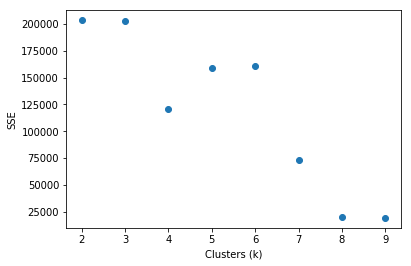

In [32]:
plt.xlabel('Clusters (k)')
plt.ylabel('SSE')
plt.scatter(k_range,errors)
plt.show()

In [33]:
k=4
kmeans = KMeans().setK(k).setMaxIter(100).setInitMode("random")
clusters_df = kmeans.fit(yelp_train_dining_df)

In [34]:
# Evaluate clustering by computing Within Set Sum of Squared Errors for test data for ml dataframe
WSSSE_train_df = clusters_df.computeCost(yelp_train_dining_df)
WSSSE_test_df = clusters_df.computeCost(yelp_test_dining_df)
print("Within Set Sum of Squared Error for train data = " + str(WSSSE_train_df))
print("Within Set Sum of Squared Error for testing data = " + str(WSSSE_test_df))

Within Set Sum of Squared Error for train data = 120926.633281
Within Set Sum of Squared Error for testing data = 12465.4521734


### Shows the result of clustering

In [34]:
#ml
centers = clusters_df.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[   0.71407186 -112.00025064   33.49066253]
[  0.78608408 -80.85494166  40.98775951]
[   0.69724335 -115.17009787   36.12162809]
[  0.75569247 -83.76058738  37.69801246]


In [35]:
lon_centers = [center[1] for center in centers]
#print(lon_centers)
lat_centers = [center[2] for center in centers]
#print(lat_centers)
isopen_centers = [center[0] for center in centers]
selected_clus=isopen_centers.index(max(isopen_centers))+1
print("The maximum open rate of %0.4f is in cluster %d." % (max(isopen_centers), selected_clus))
x_sel, y_sel = lat_centers[selected_clus-1], lon_centers[selected_clus-1]

The maximum open rate of 0.7861 is in cluster 2.


C:\Anaconda2\envs\hadoop\lib\site-packages\mpl_toolkits\basemap\__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Anaconda2\envs\hadoop\lib\site-packages\mpl_toolkits\basemap\__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
C:\Anaconda2\envs\hadoop\lib\site-packages\mpl_toolkits\basemap\__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Anaconda2\envs\hadoop\lib\site-packages\mpl_toolkits\basemap\__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


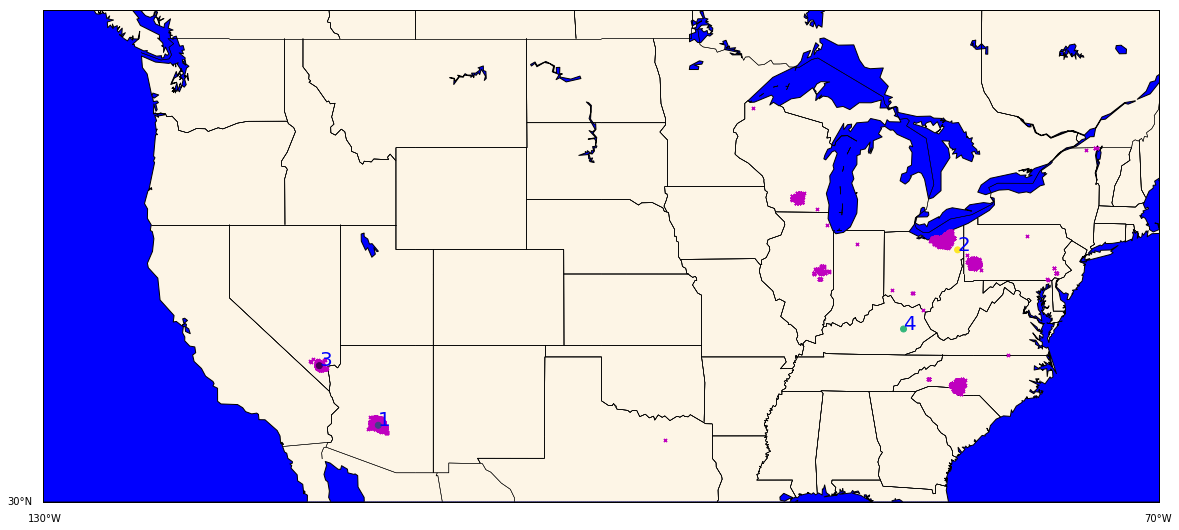

In [36]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20,10))

# miller projection
#map = Basemap(projection='mill',lon_0=180, resolution='c')
map = Basemap(projection='merc', 
              lat_0=0, lon_0=0,
              resolution = 'l', area_thresh = 1000.0,
              llcrnrlon=-130, llcrnrlat=30,
              urcrnrlon=-70, urcrnrlat=50)
# plot coastlines, draw label meridians and parallels.
map.drawcountries()
map.drawstates()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
map.drawmapboundary(fill_color='blue')
map.fillcontinents(color='oldlace',lake_color='blue')
map.drawcoastlines()
map.drawcountries(color='black')
map.drawstates()
#lats
lats = [float(v) for v in yelp_business_dining_geo_pd['latitude']][:]
lons = [float(v) for v in yelp_business_dining_geo_pd['longitude']][:]

x, y = map(lons[:], lats[:])
map.scatter(x,y,10,marker='x',color='m', zorder=50)

x_cent, y_cent = map(lon_centers[:], lat_centers[:])
map.scatter(x_cent, y_cent, marker='o', c=isopen_centers, zorder=50)
labels = range(1,6,1)
for label, xpt, ypt in zip(labels, x_cent, y_cent):
    plt.text(xpt, ypt, label, fontsize=20, color='blue', zorder=100)
plt.show()

### Get the clusters for all of the points

Append predictions to the dataframe.

In [37]:
predictions = clusters_df.transform(df_for_kmeans)
predictions.take(10)
yelp_business_geo_dining_w_pred  = predictions.join(yelp_business_dining, 'business_id')

View the dataframe.

In [38]:
yelp_business_geo_dining_w_pred.take(10)#Note that cluster numbering here starts from 0.

[Row(business_id=u'PfOCPjBrlQAnz__NXj9h_w', features=DenseVector([1.0, -81.4757, 41.1195]), prediction=1, name=u'Brick House Tavern + Tap', neighborhood=None, address=u'581 Howe Ave', city=u'Cuyahoga Falls', state=u'OH', postal_code=u'44221', latitude=41.1195346, longitude=-81.4756898, stars=3.5, review_count=116, is_open=1, categories=u'American (New);Nightlife;Bars;Sandwiches;American (Traditional);Burgers;Restaurants'),
 Row(business_id=u'EsMcGiZaQuG1OOvL9iUFug', features=DenseVector([1.0, -80.0913, 40.6151]), prediction=1, name=u'Any Given Sundae', neighborhood=None, address=u'2612 Brandt School Rd', city=u'Wexford', state=u'PA', postal_code=u'15090', latitude=40.6151022445, longitude=-80.0913487465, stars=5.0, review_count=15, is_open=1, categories=u'Coffee & Tea;Ice Cream & Frozen Yogurt;Food'),
 Row(business_id=u'XOSRcvtaKc_Q5H1SAzN20A', features=DenseVector([0.0, -80.2128, 40.2415]), prediction=1, name=u'East Coast Coffee', neighborhood=None, address=u'737 West Pike St', city=u

Filter out data not in the selected cluster.

In [39]:
#Note: selected clus started numbering from 1, so need to subtract 1 to match predictions
yelp_business_geo_dining_selected_cluster = yelp_business_geo_dining_w_pred.filter(yelp_business_geo_dining_w_pred.prediction==(selected_clus-1))
yelp_business_geo_dining_selected_cluster.take(2)

[Row(business_id=u'PfOCPjBrlQAnz__NXj9h_w', features=DenseVector([1.0, -81.4757, 41.1195]), prediction=1, name=u'Brick House Tavern + Tap', neighborhood=None, address=u'581 Howe Ave', city=u'Cuyahoga Falls', state=u'OH', postal_code=u'44221', latitude=41.1195346, longitude=-81.4756898, stars=3.5, review_count=116, is_open=1, categories=u'American (New);Nightlife;Bars;Sandwiches;American (Traditional);Burgers;Restaurants'),
 Row(business_id=u'EsMcGiZaQuG1OOvL9iUFug', features=DenseVector([1.0, -80.0913, 40.6151]), prediction=1, name=u'Any Given Sundae', neighborhood=None, address=u'2612 Brandt School Rd', city=u'Wexford', state=u'PA', postal_code=u'15090', latitude=40.6151022445, longitude=-80.0913487465, stars=5.0, review_count=15, is_open=1, categories=u'Coffee & Tea;Ice Cream & Frozen Yogurt;Food')]

Remove cluster label as it is no longer needed

In [41]:
yelp_business_geo_dining_selected_cluster=yelp_business_geo_dining_selected_cluster.drop("prediction")
yelp_business_geo_dining_selected_cluster.take(2)

[Row(business_id=u'PfOCPjBrlQAnz__NXj9h_w', features=DenseVector([1.0, -81.4757, 41.1195]), name=u'Brick House Tavern + Tap', neighborhood=None, address=u'581 Howe Ave', city=u'Cuyahoga Falls', state=u'OH', postal_code=u'44221', latitude=41.1195346, longitude=-81.4756898, stars=3.5, review_count=116, is_open=1, categories=u'American (New);Nightlife;Bars;Sandwiches;American (Traditional);Burgers;Restaurants'),
 Row(business_id=u'EsMcGiZaQuG1OOvL9iUFug', features=DenseVector([1.0, -80.0913, 40.6151]), name=u'Any Given Sundae', neighborhood=None, address=u'2612 Brandt School Rd', city=u'Wexford', state=u'PA', postal_code=u'15090', latitude=40.6151022445, longitude=-80.0913487465, stars=5.0, review_count=15, is_open=1, categories=u'Coffee & Tea;Ice Cream & Frozen Yogurt;Food')]

In [40]:
from pyspark.sql.functions import udf
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc_p)
from pyspark.sql.types import *
def SubType(s):
    if "French" in s:
        return "French"
    elif "Italian" in s:
        return "Italian" 
    elif "Mexican" in s:
        return "Mexican"
    elif "Chinese" in s or "Indian" in s or "Japanese" in s or "Korean" in s or "Thai" in s or "Asian" in s:
        return "Asian"
    elif "American" in s:
        return "American"    
    else:
        return "Other"

#American Food
#Asian Fusion (Chinese, Indian, Japanese, Korean, Thai food and so on)
#Frech Food
#Italian Food
#Mexican Food
   
subtype_function_udf = udf(SubType, StringType())

In [42]:
def getLabel(s_in):

    if s_in == "American" :
        return 0
    elif s_in == "Italian":
        return 1   
    elif s_in == "French":
        return 2
    elif s_in == "Mexican":
        return 3
    elif s_in == "Asian":
        return 4    
    else:#catchall just in case
        return -1
    
getlabel_function_udf = udf(getLabel, IntegerType())

In [43]:
def roundDouble(d_in):
    d_in = round(float(d_in))
    return int(d_in)    

rounddobule_function_udf = udf(roundDouble, IntegerType())

### Add food subcategory

In [44]:

yelp_business_geo_dining_selected_cluster_df=yelp_business_geo_dining_selected_cluster
yelp_business_geo_dining_selected_cluster_df=\
yelp_business_geo_dining_selected_cluster_df.withColumn('subcat',subtype_function_udf(yelp_business_geo_dining_selected_cluster_df['categories']))
b_ids_in_cluster = yelp_business_geo_dining_selected_cluster_df.select('business_id').collect()
b_subtypes_in_cluster = yelp_business_geo_dining_selected_cluster_df.select('subcat').collect()

Get a list of the IDs and categories in the cluster and put them in a dictionary.

In [45]:
b_ids_in_cluster = [x[0].encode('utf-8') for x in b_ids_in_cluster]
b_subtypes_in_cluster = [x[0].encode('utf-8') for x in b_subtypes_in_cluster] 
subtype_dictionary = dict(zip(b_ids_in_cluster, b_subtypes_in_cluster))

Only leave non-Other items.

In [46]:
subtype_dictionary_new = dict((key, value) for key,value in subtype_dictionary.iteritems() if value!="Other")
#Check
"Other" in subtype_dictionary_new.values()

False

View first ten entries of dictionary

In [47]:
print({k: subtype_dictionary_new[k] for k in subtype_dictionary_new.keys()[0:10]})

{'HgSsIF4PpESGUMu-rNPg0g': 'American', 'ewleimx1N5LR580XGMNnTA': 'Italian', 'Ladt7CobMcCFZ8-iC5v0cw': 'American', 'nkubaPIxnt6ZYhjKsAe3yg': 'Asian', 'pRNz6EPc6ekD1lTxRZ3I4A': 'American', 'RHhjgjO1gVmO_xGCUYqLwA': 'American', '-06-Fdi30wJx-JA8P7CAng': 'Asian', 'QiqTldItGyzTw4P6dW8RZw': 'Mexican', 'XHK_1UM4CBZQ7RemDFr1mQ': 'Asian', 'KiG6wzSo1P5vFJ_YZjM7UA': 'Italian'}


# Text Classification

### Read in yelp reviews

While it may be a bad idea to read in such a large file with pandas in general, in this case, it is read in by chunking and only the part of each chunk needed is retained, so it is not too bad here.

In [48]:
import time
chunksize = 10000
filename="yelp_review.csv"
count=1
chunks = []


beg_ts = time.time()
avg_time_chunk=[]
num_chunks=0
for chunk in pd.read_csv(filename, chunksize=chunksize, usecols=["business_id", "stars", "text"]):#names=["business_id", "stars"]
    ch_start=time.time()
    num_chunks = num_chunks+1
   
    #process_data(chunk, num_chunks)
    chunk = chunk[chunk["business_id"].isin(subtype_dictionary_new.keys())]
    chunks.append(chunk)
    
    ch_end=time.time()
    avg_time_chunk.append(ch_end-ch_start)
    
    count+=1
    print("Completed chunk %d." %(count))
    if count>500000:
        break
end_ts=time.time()
print ("It took " + str(end_ts - beg_ts)) + str(" seconds to read in the file.")
print ("Average time for processing one chunk of"+ str(count) + "chunks is "+ str( np.mean(avg_time_chunk)))+ str(".")

print("There were %d chunks and %d rows all togehter." %(count, count*chunksize))
df_pd = pd.concat(chunks, ignore_index=True)
print("There were %d rows selected." %(len(df_pd)))
df_pd.dropna(axis=0, how="any", inplace=True)
n_final = len(df_pd)
print("There were %d rows selected after dropping." %(n_final))

Completed chunk 2.
Completed chunk 3.
Completed chunk 4.
Completed chunk 5.
Completed chunk 6.
Completed chunk 7.
Completed chunk 8.
Completed chunk 9.
Completed chunk 10.
Completed chunk 11.
Completed chunk 12.
Completed chunk 13.
Completed chunk 14.
Completed chunk 15.
Completed chunk 16.
Completed chunk 17.
Completed chunk 18.
Completed chunk 19.
Completed chunk 20.
Completed chunk 21.
Completed chunk 22.
Completed chunk 23.
Completed chunk 24.
Completed chunk 25.
Completed chunk 26.
Completed chunk 27.
Completed chunk 28.
Completed chunk 29.
Completed chunk 30.
Completed chunk 31.
Completed chunk 32.
Completed chunk 33.
Completed chunk 34.
Completed chunk 35.
Completed chunk 36.
Completed chunk 37.
Completed chunk 38.
Completed chunk 39.
Completed chunk 40.
Completed chunk 41.
Completed chunk 42.
Completed chunk 43.
Completed chunk 44.
Completed chunk 45.
Completed chunk 46.
Completed chunk 47.
Completed chunk 48.
Completed chunk 49.
Completed chunk 50.
Completed chunk 51.
Complete

Completed chunk 398.
Completed chunk 399.
Completed chunk 400.
Completed chunk 401.
Completed chunk 402.
Completed chunk 403.
Completed chunk 404.
Completed chunk 405.
Completed chunk 406.
Completed chunk 407.
Completed chunk 408.
Completed chunk 409.
Completed chunk 410.
Completed chunk 411.
Completed chunk 412.
Completed chunk 413.
Completed chunk 414.
Completed chunk 415.
Completed chunk 416.
Completed chunk 417.
Completed chunk 418.
Completed chunk 419.
Completed chunk 420.
Completed chunk 421.
Completed chunk 422.
Completed chunk 423.
Completed chunk 424.
Completed chunk 425.
Completed chunk 426.
Completed chunk 427.
Completed chunk 428.
Completed chunk 429.
Completed chunk 430.
Completed chunk 431.
Completed chunk 432.
Completed chunk 433.
Completed chunk 434.
Completed chunk 435.
Completed chunk 436.
Completed chunk 437.
Completed chunk 438.
Completed chunk 439.
Completed chunk 440.
Completed chunk 441.
Completed chunk 442.
Completed chunk 443.
Completed chunk 444.
Completed chu

In [49]:
len(subtype_dictionary_new.keys())#number of keys

2310

In [50]:
review_df_filtered = spark_p.createDataFrame(df_pd)

In [51]:
def nonasciitoascii(unicodestring):
  return unicodestring.encode("ascii","ignore")
convertedudf = udf(nonasciitoascii)

In [52]:
review_df_filtered = review_df_filtered.withColumn("text_con", convertedudf(review_df_filtered.text)).drop("text")


In [53]:
review_df_filtered.limit(n_final).describe("business_id", "stars", "text_con").show()

+-------+--------------------+------------------+--------------------+
|summary|         business_id|             stars|            text_con|
+-------+--------------------+------------------+--------------------+
|  count|              112572|            112572|              112572|
|   mean|                null|  3.67398642646484|                45.0|
| stddev|                null|1.3444105643669082|   49.49747468305833|
|    min|--I7YYLada0tSLkOR...|                 1|                    |
|    max|zzwhN7x37nyjP0ZM8...|                 5|~~~The Deal-o ~~~...|
+-------+--------------------+------------------+--------------------+



In [54]:
#Check that there are no businesses that are not in the cluster.
from pyspark.sql.functions import col
review_df_filtered.filter(~col("business_id").isin(subtype_dictionary_new.keys())).show(1,False)

+-----------+-----+--------+
|business_id|stars|text_con|
+-----------+-----+--------+
+-----------+-----+--------+



Aggregrate reviews by business

In [54]:
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import avg
review_df_filtered1 = review_df_filtered.groupby("business_id").\
agg(collect_list("text_con"), avg("stars")).drop("stars")

In [55]:
review_df_filtered1=review_df_filtered1.sort("business_id")

In [56]:
review_df_filtered1.count()

2310

In [57]:
review_df_filtered1.dtypes

[('business_id', 'string'),
 ('collect_list(text_con)', 'array<string>'),
 ('avg(stars)', 'double')]

In [58]:
#Add food subcategories.
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, create_map, lit
from itertools import chain

mapping_expr = create_map([lit(x) for x in chain(*subtype_dictionary_new.items())])

review_df_filtered_temp=review_df_filtered1.withColumn("subcat", mapping_expr.getItem(col("business_id")))


In [59]:
review_df_filtered_temp.groupby('subcat').count().show()


+--------+-----+
|  subcat|count|
+--------+-----+
| Mexican|  239|
| Italian|  429|
|  French|   21|
|   Asian|  497|
|American| 1124|
+--------+-----+



Add numeric food label for category.

In [60]:
review_df_filtered_e=review_df_filtered_temp.withColumn("label", getlabel_function_udf(review_df_filtered_temp['subcat']))

In [61]:
#Check
review_df_filtered_e.groupby('label', 'subcat').count().show()

+-----+--------+-----+
|label|  subcat|count|
+-----+--------+-----+
|    1| Italian|  429|
|    2|  French|   21|
|    0|American| 1124|
|    4|   Asian|  497|
|    3| Mexican|  239|
+-----+--------+-----+



In [62]:
 review_df_filtered_e.groupby('subcat').agg(avg('avg(stars)')).show()

+--------+------------------+
|  subcat|   avg(avg(stars))|
+--------+------------------+
| Mexican|3.3305667575021887|
| Italian| 3.447052329257577|
|  French| 4.087999053900416|
|   Asian| 3.537010405738783|
|American| 3.419426785587261|
+--------+------------------+



In [63]:
review_df_filtered_e = review_df_filtered_e.withColumn("avg(stars)1", 
                                                       rounddobule_function_udf(review_df_filtered_temp["avg(stars)"]))

In [64]:
review_df_filtered_e.select('avg(stars)1').take(3)

[Row(avg(stars)1=3), Row(avg(stars)1=4), Row(avg(stars)1=4)]

In [65]:
review_df_filtered_e=review_df_filtered_e.\
withColumn('text', review_df_filtered_e['collect_list(text_con)'].cast("string"))
#review_df_filtered_e=review_df_filtered_e.drop('collect_list(text_con)')
#review_df_filtered_e.show(1)

In [66]:
review_df_filtered_e.dtypes

[('business_id', 'string'),
 ('collect_list(text_con)', 'array<string>'),
 ('avg(stars)', 'double'),
 ('subcat', 'string'),
 ('label', 'int'),
 ('avg(stars)1', 'int'),
 ('text', 'string')]

In [67]:
summary = review_df_filtered_e.groupby('subcat').agg(avg('avg(stars)1'))
summary.show()

+--------+------------------+
|  subcat|  avg(avg(stars)1)|
+--------+------------------+
| Mexican|3.3305439330543933|
| Italian|3.4428904428904428|
|  French| 4.142857142857143|
|   Asian|3.5593561368209254|
|American| 3.445729537366548|
+--------+------------------+



## Select the category.

Select the category with the highest number of stars.

In [68]:
row_max=summary.agg({'avg(avg(stars)1)':'max'}).collect()[0]
max_stars=row_max["max(avg(avg(stars)1))"]
#print max_stars
categ_sel = str(summary.filter(col('avg(avg(stars)1)')==max_stars).collect()[0][0])
print ("The category with the highest average number of stars is %s." % categ_sel)


The category with the highest average number of stars is French.


In [69]:
count_sel = row1 = review_df_filtered_e.groupby('label', 'subcat').count().filter(col('subcat')==categ_sel).select('count').collect()[0][0]
if count_sel<100:
    print("Choosing a category with more points as the chosen one ony had %d." %count_sel)

Choosing a category with more points as the chosen one ony had 21.


In [70]:
if count_sel<100:
    summary_red = summary.filter(col('subcat')!=categ_sel)
    summary_red.show()

+--------+------------------+
|  subcat|  avg(avg(stars)1)|
+--------+------------------+
| Mexican|3.3305439330543933|
| Italian|3.4428904428904428|
|   Asian|3.5593561368209254|
|American| 3.445729537366548|
+--------+------------------+



In [71]:
if count_sel<100:
    row_max=summary_red.agg({'avg(avg(stars)1)':'max'}).collect()[0]
    max_stars=row_max["max(avg(avg(stars)1))"]
    print max_stars    
    categ_sel = str(summary_red.filter(col('avg(avg(stars)1)')==max_stars).collect()[0][0])
    print ("The category with the highest average number of stars with enough points is %s." % categ_sel)

3.55935613682
The category with the highest average number of stars with enough points is Asian.


## Set up the pipeline to prepare for classification (supervised learning).

In [72]:
from pyspark.ml.feature import RegexTokenizer

#Get alpha only rather than #\w+
regexTokenizer = RegexTokenizer(gaps = False, pattern = '[a-zA-Z]+', inputCol = 'text', outputCol = 'features_token', minTokenLength=2).setToLowercase(True)


In [73]:
from pyspark.ml.feature import StopWordsRemover
#Display stop words
StopWordsRemover.loadDefaultStopWords("english")
stopwordsRemover = StopWordsRemover(inputCol = regexTokenizer.getOutputCol(), outputCol = "no_sw" )


In [74]:
from pyspark.ml.feature import CountVectorizer
# bag of words count
countVectors = CountVectorizer(inputCol=stopwordsRemover.getOutputCol(), outputCol="features_before_scaling", vocabSize=100, minDF=20)


In [75]:
from pyspark.ml.feature import IDF
idfIgnore = IDF(minDocFreq=20,inputCol=countVectors.getOutputCol(),outputCol="features")

In [76]:
from pyspark.ml import Pipeline
#pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, idfIgnore]) 
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, idfIgnore]) 

In [77]:
pipelineFit = pipeline.fit(review_df_filtered_e)
dataset = pipelineFit.transform(review_df_filtered_e)
stages = pipelineFit.stages

View the results of the pipeline.

In [78]:
from pyspark.ml.feature import CountVectorizerModel

vectorizers = [s for s in stages if isinstance(s, CountVectorizerModel)]
vocab = [v.vocabulary for v in vectorizers][0]
print(vocab)

[u'food', u'good', u'place', u'great', u'like', u'service', u'one', u'time', u'get', u'back', u'go', u'really', u'restaurant', u'ordered', u'also', u'menu', u've', u'chicken', u'us', u'got', u'nice', u'well', u'bar', u'order', u'best', u'delicious', u'little', u'try', u'came', u'even', u'sauce', u'always', u'love', u'cheese', u'definitely', u'pretty', u'much', u'first', u'didn', u'went', u'beer', u'never', u'table', u'dinner', u'meal', u'friendly', u'pizza', u'night', u'staff', u'made', u'come', u'eat', u'salad', u'wait', u'better', u'people', u'lunch', u'fresh', u'two', u'experience', u'amazing', u'make', u'fries', u're', u'think', u'side', u'way', u'ever', u'server', u'everything', u'burger', u'drinks', u'take', u'atmosphere', u'know', u'say', u'going', u'bit', u'area', u'right', u'minutes', u'pittsburgh', u'sandwich', u'small', u'still', u'said', u'want', u'bad', u'around', u'excellent', u'though', u'times', u'sure', u'wasn', u'dish', u'recommend', u'something', u'll', u'favorite', 

The IDF output is a scaled version of the countVectorizer output, which can be dropped.

In [79]:
dataset=dataset.drop('text_con', 'no_sw', 'features_token', 'features_before_scaling', 'text')#intermediate outputs not needed

In [80]:
dataset.select('features').head()

Row(features=SparseVector(100, {0: 1.2768, 1: 2.5603, 2: 1.9066, 3: 2.9829, 4: 1.2225, 5: 3.4721, 6: 1.2474, 7: 1.8735, 8: 1.7413, 9: 2.5728, 10: 1.9827, 11: 3.9491, 12: 1.462, 13: 2.3206, 14: 1.9703, 15: 1.4486, 16: 1.1923, 17: 5.2921, 18: 4.6689, 19: 3.2429, 20: 2.0886, 21: 1.6354, 22: 11.3362, 23: 1.2249, 24: 1.5162, 25: 1.1054, 26: 1.0936, 27: 1.1233, 28: 3.292, 29: 1.9306, 30: 2.737, 31: 2.6971, 32: 0.7984, 33: 0.4111, 34: 2.4105, 35: 3.5609, 36: 2.1298, 37: 2.0806, 38: 3.6943, 39: 1.9416, 40: 15.7018, 41: 0.7644, 42: 4.7764, 43: 2.0542, 44: 0.9318, 45: 3.1333, 47: 4.0513, 48: 1.8451, 49: 1.5496, 50: 3.0273, 51: 0.9378, 52: 3.7455, 53: 2.783, 54: 1.7886, 55: 0.7215, 56: 1.0399, 57: 0.8376, 58: 1.7617, 59: 1.6694, 60: 2.4981, 61: 0.5031, 62: 14.7016, 63: 0.9071, 64: 1.8494, 65: 2.5084, 66: 1.9545, 67: 1.7961, 68: 3.3557, 69: 0.6342, 70: 14.0523, 71: 3.7942, 72: 0.8652, 73: 4.8984, 75: 3.0236, 76: 1.6138, 77: 1.5592, 78: 1.3533, 79: 0.593, 80: 2.1836, 82: 12.1107, 83: 0.7517, 84: 0.

In [81]:
dataset.select('features', 'avg(stars)1').show(2, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [82]:
dataset.columns

['business_id',
 'collect_list(text_con)',
 'avg(stars)',
 'subcat',
 'label',
 'avg(stars)1',
 'features']

In [83]:
dataset.groupby('avg(stars)1').mean().show()

+-----------+------------------+------------------+----------------+
|avg(stars)1|   avg(avg(stars))|        avg(label)|avg(avg(stars)1)|
+-----------+------------------+------------------+----------------+
|          1|1.2482634830650676|               1.0|             1.0|
|          3| 3.069558679959741|1.2922535211267605|             3.0|
|          5| 4.676653182465721|1.2015503875968991|             5.0|
|          4|3.9113541054188086|1.4875115633672527|             4.0|
|          2| 2.146400493794498| 1.279475982532751|             2.0|
+-----------+------------------+------------------+----------------+



In [84]:
dataset.describe()

DataFrame[summary: string, business_id: string, avg(stars): string, subcat: string, label: string, avg(stars)1: string]

In [87]:
schema1 = dataset.schema
schema1


StructType(List(StructField(business_id,StringType,true),StructField(collect_list(text_con),ArrayType(StringType,true),true),StructField(avg(stars),DoubleType,true),StructField(subcat,StringType,true),StructField(label,IntegerType,true),StructField(avg(stars)1,IntegerType,true),StructField(features,VectorUDT,true)))

In [9]:
s_path = YELP_DIR + 'yelp_business_text/' + 'dataset1'

In [10]:
dataset.rdd.saveAsTextFile(s_path)

NameError: name 'dataset' is not defined

Read back in.

In [32]:
dataset_rdd=sc_p.textFile(s_path)
dataset_rdd.take(1)

[u'Row(business_id=u\'--I7YYLada0tSLkORTHb5Q\', collect_list(text_con)=[u\'We were a group of 4 had dinner last night 3 had burgers 1 had the rib special,chicken nachos for an app.\\nService was very good,all agreed food was also very good much better than our first experience here a year ago\', u"My husband and I ate here yesterday and both were told how wonderful the fish sandwich was. So we ordered it. First the fries that came along with sandwich were limp and greasy. It is pretty hard to mess up fries but they did. The fish was a glorified frozen fish stick with breading looks like a very large chicken McNugget. It was served on what looked like a yummy French baguette. It wasn\'t. It was bland, tasteless and rubbery. We asked for the Catawba sauce (mayo and siracha) which turned out to be the only good tasting thing we ordered. Don\'t order the fish sandwich no matter what anyone says, unless you like fish McNugget sandwiches.  $42.00 for two fish sandwiches and fries that we did

In [38]:
from pyspark.sql.types import *
schema = StructType([
StructField("business_id", StringType(), True),
StructField("collect_list(text_con)", StringType(), True),
StructField("avg(stars)", IntegerType(), True),
StructField('subcat', StringType(), True),
 StructField('label',  IntegerType(), True),
  StructField('avg(stars)1',IntegerType(), True), 
  StructField('features', StringType(), True)]) 

In [56]:
dataset = dataset_rdd.toDF(schema)
dataset.dtypes

[('business_id', 'string'),
 ('collect_list(text_con)', 'string'),
 ('avg(stars)', 'int'),
 ('subcat', 'string'),
 ('label', 'int'),
 ('avg(stars)1', 'int'),
 ('features', 'string')]

In [57]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
parse = udf(lambda x: Vectors.parse(x).asML(), VectorUDT())
dataset = dataset.withColumn('features', parse('features'))

In [58]:
dataset.dtypes

[('business_id', 'string'),
 ('collect_list(text_con)', 'string'),
 ('avg(stars)', 'int'),
 ('subcat', 'string'),
 ('label', 'int'),
 ('avg(stars)1', 'int'),
 ('features', 'vector')]

Split the data into training and test datasets.

In [89]:
(training_data, test_data) = dataset.randomSplit([0.7, 0.3], seed = 24)

#### Try Naive Bayes classification as a baseline.

In [90]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1,  modelType="multinomial",featuresCol='features', labelCol='label', predictionCol='prediction')
model_nb = nb.fit(training_data)

Check the model on the test set.

In [93]:
predictions_nb = model_nb.transform(test_data)

In [94]:
predictions_nb.select('label', 'prediction').show(10, True)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    3|       3.0|
|    0|       4.0|
|    0|       3.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    3|       3.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



In [95]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

In [96]:
print(evaluator.metricName)
print(evaluator.explainParams())

MulticlassClassificationEvaluator_49a69a01771377465122__metricName
labelCol: label column name. (default: label)
metricName: metric name in evaluation (f1|weightedPrecision|weightedRecall|accuracy) (default: f1)
predictionCol: prediction column name. (default: prediction, current: prediction)


f1 score

In [98]:
evaluator.evaluate(predictions_nb)

0.7067230468038984

accuracy

In [525]:
evaluator = evaluator.setMetricName("accuracy")

In [99]:
evaluator.evaluate(predictions_nb)

0.7067230468038984

In [537]:
#Check
model_nb.numClasses

5

#### Try multiclass Logistic Regression.

First try the default model.

In [100]:
from pyspark.ml.classification import LogisticRegression

#predictionCol='prediction'
lr = LogisticRegression(family="multinomial", featuresCol='features', labelCol='label', predictionCol='prediction')
model_lr = lr.fit(training_data)

In [117]:
predictions_lr_def = model_lr.transform(test_data)

In [118]:
predictions_lr_def.select('label', 'prediction').show(10, True)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    3|       3.0|
|    0|       1.0|
|    0|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       0.0|
|    3|       3.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



Now, try using cross-validation to select the best logistic regression model.

In [104]:
from pyspark.ml.classification import LogisticRegression
lr_cv = LogisticRegression(family="multinomial", maxIter=10)

Set up the parameter grid.

In [127]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_cv.regParam, [0.001, 0.01]) \
    .build()  
   

In [128]:
import pprint
for p in paramGrid_lr:
    print(p)

{Param(parent=u'LogisticRegression_49279ccaab8aab6cc86c', name='regParam', doc='regularization parameter (>= 0).'): 0.001}
{Param(parent=u'LogisticRegression_49279ccaab8aab6cc86c', name='regParam', doc='regularization parameter (>= 0).'): 0.01}


Select the best model using cross-validation.

In [129]:
lr_ev = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')
crossval_lr = CrossValidator(estimator=lr_cv, estimatorParamMaps=paramGrid_lr, evaluator = lr_ev, numFolds= 10, parallelism=8)  

In [131]:
cvModel_lr = crossval_lr.fit(training_data)

In [132]:
predictions_lr = cvModel_lr.bestModel.transform(test_data)

In [133]:
predictions_lr.select("label", "prediction").take(11)

[Row(label=0, prediction=0.0),
 Row(label=0, prediction=0.0),
 Row(label=3, prediction=0.0),
 Row(label=0, prediction=0.0),
 Row(label=0, prediction=0.0),
 Row(label=1, prediction=1.0),
 Row(label=1, prediction=0.0),
 Row(label=0, prediction=0.0),
 Row(label=3, prediction=4.0),
 Row(label=0, prediction=0.0),
 Row(label=1, prediction=1.0)]

f1 score

In [134]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions_lr)

0.6656368867785614

accuracy

In [135]:
evaluator = evaluator.setMetricName("accuracy")
evaluator.evaluate(predictions_lr)

0.6931506849315069

f1 score for the default model

In [119]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions_lr_def)

0.705600095895541

accuracy for the default model

In [120]:
evaluator = evaluator.setMetricName("accuracy")
evaluator.evaluate(predictions_lr_def)

0.7136986301369863

In [136]:
print(cvModel_lr.bestModel.summary.labels)
print(cvModel_lr.bestModel.summary.precisionByLabel)
print(cvModel_lr.bestModel.summary.falsePositiveRateByLabel)

[0.0, 1.0, 2.0, 3.0, 4.0]
[0.7158203125, 0.85, 0.0, 0.7142857142857143, 0.7682926829268293]
[0.36788874841972186, 0.023059185242121444, 0.0, 0.0056179775280898875, 0.06143896523848019]


In [122]:
print(model_lr.summary.labels)
print(model_lr.summary.precisionByLabel)
print(model_lr.summary.falsePositiveRateByLabel)

[0.0, 1.0, 2.0, 3.0, 4.0]
[0.8496503496503497, 0.847457627118644, 1.0, 0.7753623188405797, 0.8813056379821959]
[0.16308470290771176, 0.027671022290545733, 0.0, 0.021769662921348316, 0.03233629749393695]


The default model seems to perform better, but why? 
The available parameters are:

In [374]:
cvModel_lr.params

[Param(parent=u'LogisticRegression_4f838df5e3ae8fbb1fe6', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent=u'LogisticRegression_4f838df5e3ae8fbb1fe6', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent=u'LogisticRegression_4f838df5e3ae8fbb1fe6', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent=u'LogisticRegression_4f838df5e3ae8fbb1fe6', name='featuresCol', doc='features column name.'),
 Param(parent=u'LogisticRegression_4f838df5e3ae8fbb1fe6', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent=u'LogisticRegression_4f838df5e3ae8fbb1fe6', name='labelCol', doc='label column name.'),
 Param(parent=u'LogisticRegression_4f838df5e3ae8fbb1fe6', name='lowerBoundsOnCoefficients', do

In [137]:
cv_java_model = cvModel_lr.bestModel._java_obj
for param in cvModel_lr.bestModel.params:
    try:
        print(param.name, cv_java_model.getOrDefault(cv_java_model.getParam(param.name)))
    except:
        print("Failed for", param.name)

('aggregationDepth', 2)
('elasticNetParam', 0.0)
('family', u'multinomial')
('featuresCol', u'features')
('fitIntercept', True)
('labelCol', u'label')
('Failed for', 'lowerBoundsOnCoefficients')
('Failed for', 'lowerBoundsOnIntercepts')
('maxIter', 10)
('predictionCol', u'prediction')
('probabilityCol', u'probability')
('rawPredictionCol', u'rawPrediction')
('regParam', 0.001)
('standardization', True)
('threshold', 0.5)
('Failed for', 'thresholds')
('tol', 1e-06)
('Failed for', 'upperBoundsOnCoefficients')
('Failed for', 'upperBoundsOnIntercepts')
('Failed for', 'weightCol')


In [126]:
java_model = model_lr._java_obj
for param in cvModel_lr.bestModel.params:
    try:
        print(param.name, java_model.getOrDefault(java_model.getParam(param.name)))
    except:
        print("Failed for", param.name)

('aggregationDepth', 2)
('elasticNetParam', 0.0)
('family', u'multinomial')
('featuresCol', u'features')
('fitIntercept', True)
('labelCol', u'label')
('Failed for', 'lowerBoundsOnCoefficients')
('Failed for', 'lowerBoundsOnIntercepts')
('maxIter', 100)
('predictionCol', u'prediction')
('probabilityCol', u'probability')
('rawPredictionCol', u'rawPrediction')
('regParam', 0.0)
('standardization', True)
('threshold', 0.5)
('Failed for', 'thresholds')
('tol', 1e-06)
('Failed for', 'upperBoundsOnCoefficients')
('Failed for', 'upperBoundsOnIntercepts')
('Failed for', 'weightCol')


Note that maxIter is set to 100 for the default model vs. 10 for the cross-validation model. Additionaly, regParam is 0.0 for the default model vs. 0.001 (the lowest value in the grid) in the cv model.

In [153]:
predictions_lr.groupby('label').avg(*['prediction']).orderBy('label').show()

+-----+------------------+
|label|   avg(prediction)|
+-----+------------------+
|    0|0.2746268656716418|
|    1|0.6866666666666666|
|    2|             1.875|
|    3|1.5421686746987953|
|    4|2.9675324675324677|
+-----+------------------+



In [154]:
predictions_lr_def.groupby('label').avg(*['prediction']).orderBy('label').show()

+-----+-------------------+
|label|    avg(prediction)|
+-----+-------------------+
|    0|0.43283582089552236|
|    1| 0.7266666666666667|
|    2|                0.5|
|    3| 2.3493975903614457|
|    4| 3.2467532467532467|
+-----+-------------------+



Both models seem to have trouble with label 2, as indicated by the precision and false positives by label, though the cross-validated model has a precision of 0 for this label.

### Find terms using model weights for the 5 star category.

Fit the model to all the data now.

In [123]:
model_lr_all = lr.fit(dataset)

In [138]:
cvModel_lr_all = crossval_lr.fit(dataset)

In [139]:
predictions_lr.select('label', 'prediction').take(10)

[Row(label=0, prediction=0.0),
 Row(label=0, prediction=0.0),
 Row(label=3, prediction=0.0),
 Row(label=0, prediction=0.0),
 Row(label=0, prediction=0.0),
 Row(label=1, prediction=1.0),
 Row(label=1, prediction=0.0),
 Row(label=0, prediction=0.0),
 Row(label=3, prediction=4.0),
 Row(label=0, prediction=0.0)]

In [142]:
def get_coeffs(spark_model):
    coeffs = [spark_model.coefficientMatrix[4,i] for i in range(0,100)]
    return coeffs

In [144]:
#Cross-valicated model.
cv_coeffs = get_coeffs(cvModel_lr_all.bestModel)
cv_sorted_coeffs = sorted(cv_coeffs)
print(cv_sorted_coeffs)
print(max(cv_coeffs))  
vocab[cv_coeffs.index(max(cv_coeffs))]

[-0.15529180588989575, -0.14324344791076202, -0.10917463917903515, -0.10446182539062585, -0.09865901560219724, -0.09252236922021873, -0.09059713332594704, -0.08842765740493899, -0.08785609075622249, -0.07892537244813691, -0.07667614461154852, -0.07436215031355896, -0.06700045793109091, -0.0657628297806443, -0.062309215486031876, -0.061418937090416105, -0.05584335855517342, -0.05525499648642378, -0.051043918613982914, -0.04908284619921142, -0.0470622597268791, -0.04671231841979992, -0.04597174968605089, -0.04551681533602115, -0.0436522078394897, -0.038558277129131166, -0.03818601332846225, -0.0381797743409044, -0.03795400293871837, -0.034442324069010516, -0.03383685155913508, -0.032550389813795634, -0.030968997178705375, -0.02802445529592824, -0.027192729237227518, -0.026925023495562403, -0.02588176739160335, -0.025560206384533674, -0.02490725016786167, -0.02222419206024814, -0.021649916144265344, -0.020797008917861154, -0.020557528641175504, -0.02030552463361663, -0.020145377448365337,

u'chicken'

In [145]:
#Default model.
coeffs = get_coeffs(model_lr)
sorted_coeffs = sorted(coeffs)
print(sorted_coeffs)
print(max(coeffs))  
vocab[coeffs.index(max(coeffs))]

[-1.9999627320406892, -1.173284637561662, -1.167007676256425, -0.9215433470113747, -0.8890752859366906, -0.8387323690847687, -0.8371786201554213, -0.7012689985298536, -0.6948965294846327, -0.6423839976568692, -0.5701867558163636, -0.5671504298183229, -0.4837738609494305, -0.46345083082442085, -0.4512503152593117, -0.4251480849069706, -0.4045293141287, -0.3875932023952906, -0.38213663632232014, -0.37857843655583295, -0.37703896196150616, -0.3500322860486305, -0.33172539007531204, -0.3252396230153621, -0.2727412234413328, -0.26861344546702143, -0.2162454946156691, -0.1609440133081354, -0.15545213559984186, -0.1522290634363648, -0.1346331948373627, -0.12306422276789299, -0.12029743077344451, -0.114925173622036, -0.11330308210438031, -0.11055867971922723, -0.10601353724660567, -0.10235493239451954, -0.10145706978441196, -0.06315767909988033, -0.0611913127094429, -0.05843340780046319, -0.05750254303425115, -0.04942347313950077, -0.03961117336019388, -0.038901829781831425, -0.013753000575459

u'take'

In [150]:
weighted_terms = { vocab[cv_coeffs.index(coeff)]: coeff for coeff in cv_sorted_coeffs if coeff>0}
weighted_terms

{u'also': 0.03965483816251744,
 u'always': 0.045510693823613654,
 u'area': 0.04593291244854858,
 u'bad': 0.04225218487102237,
 u'best': 0.04973609388388303,
 u'better': 0.024543061114919513,
 u'bit': 0.04633203496190091,
 u'chicken': 0.2419390543160943,
 u'definitely': 0.030334703318353372,
 u'delicious': 0.006594668818452365,
 u'dish': 0.0941139624835808,
 u'eat': 0.046845032991549046,
 u'everything': 0.019036329743720184,
 u'favorite': 0.06767921049784392,
 u'food': 0.20736415961998753,
 u'fresh': 0.13249588090432446,
 u'good': 0.014901069235678051,
 u'like': 0.030776467891854616,
 u'little': 0.0121756562250548,
 u'll': 0.01487357002215744,
 u'lunch': 0.19335102923645278,
 u'much': 0.04197996906449861,
 u'never': 0.013257517829445798,
 u'order': 0.1238478599326908,
 u'ordered': 0.0389897773963392,
 u'pittsburgh': 0.001405426362843209,
 u'place': 0.04145084539092371,
 u'pretty': 0.055386799170234036,
 u'really': 0.020300575341389526,
 u'recommend': 0.05133297337198782,
 u'restaurant':

In [148]:
weighted_terms = { vocab[coeffs.index(coeff)]: coeff for coeff in sorted_coeffs if coeff>0}
weighted_terms

{u'also': 1.3485207628841995,
 u'area': 0.3536163705129983,
 u'bad': 0.7341557564027164,
 u'bar': 0.00893982386774798,
 u'best': 0.5346709496140487,
 u'bit': 0.32556963821359675,
 u'came': 0.11839507066386018,
 u'chicken': 0.5046540413853825,
 u'definitely': 0.18218166811943828,
 u'didn': 0.1197650952614027,
 u'dinner': 0.41342458398261034,
 u'dish': 0.15374366549245125,
 u'drinks': 0.027563230046716243,
 u'ever': 0.9538579655669454,
 u'excellent': 0.3013633557624699,
 u'favorite': 0.00012126599820858607,
 u'first': 0.1717460413604133,
 u'food': 0.8546950370931139,
 u'fresh': 0.3008556164762732,
 u'get': 0.30665713412633056,
 u'good': 0.1649166820574975,
 u'got': 0.09466493569977348,
 u'great': 0.19209955336277187,
 u'like': 0.10147420727187971,
 u'll': 0.023886499371349294,
 u'lunch': 0.7579029267624993,
 u'make': 0.49973612640404563,
 u'minutes': 0.41261432065679926,
 u'much': 0.4375516019918762,
 u'never': 0.0555693685836049,
 u'nice': 0.6662635604220325,
 u'order': 0.40297487286169

(-0.5, 399.5, 199.5, -0.5)

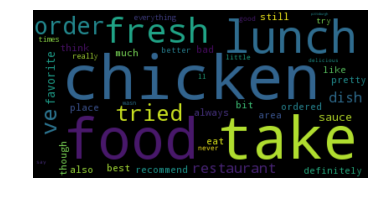

In [151]:
from PIL import Image
from wordcloud import WordCloud
wc = WordCloud()
wc.generate_from_frequencies(weighted_terms)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

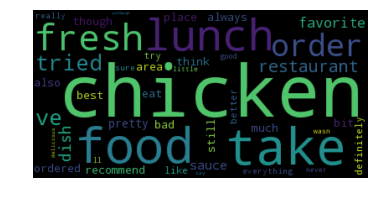

In [496]:
from PIL import Image
from wordcloud import WordCloud
wc = WordCloud()
wc.generate_from_frequencies(weighted_terms)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

So it seems that the best food to serve would be fresh chicken. :)

Potential expansions are to try other models/try using n-grams to get word context.